In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import os
from source.data_processing.image_reading import read_image
from source.data_processing.transformations import sample_random_affine_matrix
from typing import Tuple, List
from torchvision import transforms
from kornia.geometry.transform import warp_affine
from matplotlib import pyplot as plt
from source.visualization.image_visualization import plot_images_with_matches_via_mapping, plot_images_with_matches_via_match_matrix
from source.data_processing.keypoints import generate_image_grid_coordinates
from source.data_processing.transformations import *
from source.visualization.image_visualization import plot_image_with_crop

In [2]:
# class BrainDataset(Dataset):
#     def __init__(
#         self,
#         images_directory: str,
#         train: bool,
#         transform: transforms.transforms.Compose,
#     ) -> None:
#         super().__init__()
#         self.train = train
#         self.image_names = self._get_image_names(images_directory=images_directory)
#         self.images_directory = images_directory
#         self.transform = transform

#     def __len__(self) -> int:
#         """
#         Return the number of images in the dataset -1, since this dataset works with pairs of images.
#         """
#         return len(self.image_names[:-1])

#     def _get_image_names(self, images_directory: str) -> List[str]:
#         """
#         Load image names from the directory based on training or testing phase.

#         Args:
#             images_directory (str): Directory path containing images.

#         Returns:
#             List[str]: A list of image file names.
#         """
#         image_files = os.listdir(images_directory)
#         return image_files[:-2] if self.train else image_files[-2:]

#     def _get_images(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         Load a pair of images from the dataset.

#         Args:
#             index (int): Index of the pair of images.

#         Returns:
#             Tuple[torch.Tensor, torch.Tensor]: A tuple containing the images.
#         """
#         image_1 = read_image(
#             os.path.join(self.images_directory, self.image_names[index])
#         )
#         image_2 = read_image(
#             os.path.join(self.images_directory, self.image_names[index + 1])
#         )

#         image_1 = transforms.ToTensor()(image_1)
#         image_2 = transforms.ToTensor()(image_2)

#         return image_1, image_2

#     def __getitem__(self, index: int):
#         # Read whole image
#         image_1, image_2 = self._get_images(index=index)

#         if self.transform:
#             image_1 = self.transform(image_1)
#             image_2 = self.transform(image_2)

#         transformation_matrix = sample_random_affine_matrix(
#             self.transformation_threshold
#         ).to(self.device)
#         image_2_transformed = warp_affine(image_2, transformation_matrix)

In [3]:
images_directory = "data/cyto_downscaled_3344_3904/"
image_names = os.listdir(images_directory)
image_1, image_2 = read_image(
    os.path.join(images_directory, image_names[0])
), read_image(os.path.join(images_directory, image_names[1]))
image_1 = transforms.ToTensor()(image_1)
image_2 = transforms.ToTensor()(image_2)

In [4]:
image_size = image_1.shape[-2:]

In [5]:
transformation_matrix = sample_random_affine_matrix(range_limit=0.3)
image_2 = warp_affine(
    src=image_2.unsqueeze(0), M=transformation_matrix, dsize=image_size, mode="nearest"
)[0]

In [6]:
grid_coordinates = generate_image_grid_coordinates(image_size)

In [7]:
image_coordinate_mapping = transform_grid_coordinates(
    grid_coordinates, transformation_matrix[0]
)

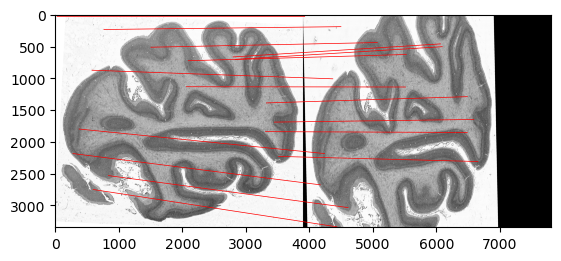

In [8]:
plot_images_with_matches_via_mapping(
    image_1,
    image_2,
    image_coordinate_mapping,
    number_of_matches=20,
    sample_keypoints_randomly=True,
)

In [9]:
from source.data_processing.cropping import sample_crop_coordinates, crop_image

In [10]:
crop_size = 640
max_translation_shift = 50

crop_position_image_1, crop_position_image_2 = sample_crop_coordinates(
    coordinate_mapping=image_coordinate_mapping,
    crop_size=crop_size,
    max_translation_shift=max_translation_shift,
)

In [11]:
crop_position_image_2

tensor([ 390, 1530])

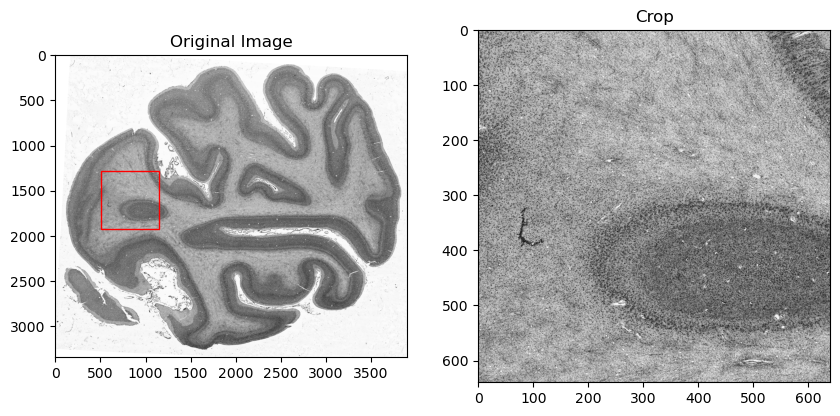

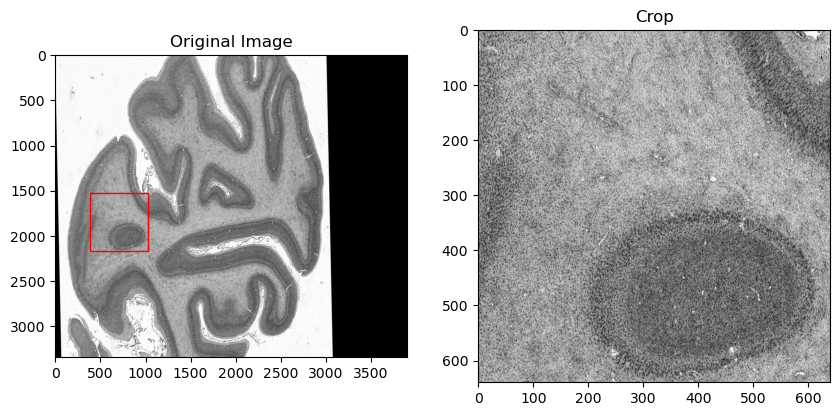

In [16]:
image_1_crop = crop_image(
    image=image_1, crop_position=crop_position_image_1, crop_size=crop_size
)
image_2_crop = crop_image(
    image=image_2, crop_position=crop_position_image_2, crop_size=crop_size
)
plot_image_with_crop(
    original_image=image_1, crop_image=image_1_crop, crop_position=crop_position_image_1
)
plot_image_with_crop(
    original_image=image_2, crop_image=image_2_crop, crop_position=crop_position_image_2
)

In [17]:
from source.data_processing.cropping import create_crop_coordinate_mapping

crop_coordinate_mapping = create_crop_coordinate_mapping(
    image_coordinate_mapping=image_coordinate_mapping,
    crop_position_image_1=crop_position_image_1,
    crop_position_image_2=crop_position_image_2,
    crop_size=crop_size,
)

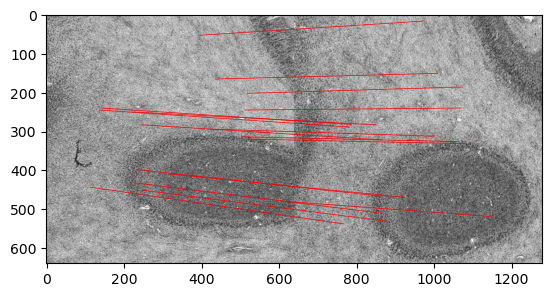

In [18]:
plot_images_with_matches_via_mapping(
    image_1_crop,
    image_2_crop,
    crop_coordinate_mapping,
    number_of_matches=20,
    sample_keypoints_randomly=True,
)

In [19]:
from source.data_processing.patch_processing import create_match_matrix

In [20]:
match_matrix = create_match_matrix(crop_coordinate_mapping, crop_size=640, patch_size=16)

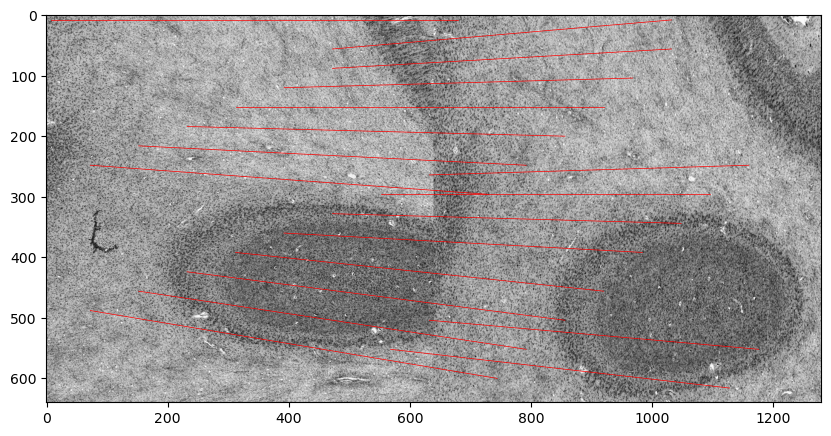

In [22]:
plot_images_with_matches_via_match_matrix(image_1_crop, image_2_crop, match_matrix, "lines")